In [11]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from darts import TimeSeries
from darts.metrics import mape, r2_score, rmse
import numpy as np
from statsmodels.tsa.api import VAR, VARMAX


import utils as utils


# Load data
df = utils.load_data()

# Convert the dataframe to multiple TimeSeries objects (one per pre-processing method)
ts, covars_diff, covars_diff_yoy, covars_nodiff = utils.df2ts(df)

# Scale the time series and covariates
covars_diff_pipeline, covars_diff_scaled = utils.scale_ts(covars_diff, should_diff=True, diff_order=1)
covars_nodiff_pipeline, covars_nodiff_scaled = utils.scale_ts(covars_nodiff, should_diff=False)
covars_diff_yoy_pipeline, covars_diff_yoy_scaled = utils.scale_ts(covars_diff_yoy,should_diff=True, diff_order=12)
pipeline, ts_scaled = utils.scale_ts(ts, should_diff=True, diff_order=1)


# Ensure that all timeseries are aligned (i.e. have the same time range). This is required for stacking them together.
covars_diff_scaled = covars_diff_scaled.slice_intersect(covars_diff_yoy_scaled)
covars_nodiff_scaled = covars_nodiff_scaled.slice_intersect(covars_diff_yoy_scaled)

# Stack the covariates
covariates_scaled = covars_diff_scaled.stack(covars_nodiff_scaled).stack(covars_diff_yoy_scaled)


# Split the data into training and validation sets
train_ts, val_ts = ts.split_after(pd.Timestamp("2016-01-01"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
def make_multivariate_time_series(ts, covariates, only_cpi=True):
    if only_cpi:
        ts_multivariate = ts.slice_intersect(covariates).stack(covariates["US_CPI"])
    else:
        ts_multivariate = ts.slice_intersect(covariates).stack(covariates)

    # Split the data into training and validation sets
    train_ts_scaled, val_ts_scaled = ts_multivariate.split_after(pd.Timestamp("2016-01-01"))

    # Reconvert to DataFrame since statsmodels does not support TimeSeries objects
    train = train_ts_scaled.pd_dataframe()
    validation = val_ts_scaled.pd_dataframe()
    history = pd.concat([train, validation])

    return train, validation, history


train, validation, history = make_multivariate_time_series(ts_scaled, covariates_scaled, only_cpi=False)

In [52]:
train.head()

component,US_TB_YIELD_10YRS,FFED,US_TB_YIELD_2YRS,US_TB_YIELD_5YRS,US_TB_YIELD_3YRS,US_CPI,US_PERSONAL_SPENDING_PCE,NEWS_SENTIMENT,US_UNEMPLOYMENT_RATE,SNP_500
DATE,,,,,,,,,,
1981-01-31,-0.861807,-0.156313,-2.021438,-1.349843,-1.668717,0.736170,-0.204928,-1.924380,1.038888,-0.282852
1981-02-28,2.093773,-5.556036,1.686885,1.900737,1.735330,1.115844,-0.063938,-1.783316,0.847842,-0.318224
1981-03-31,-0.215918,-2.351997,-0.851207,0.024028,-0.327320,0.589030,-0.125384,-1.625248,0.853907,-0.257283
1981-04-30,1.889633,2.229741,1.501043,1.729350,1.582733,0.687908,-0.166473,-1.383744,0.793257,-0.245337
1981-05-31,1.418656,4.940774,3.323203,1.878366,2.667928,0.717823,-0.117775,-1.020066,0.787192,-0.275122


# VAR Model

<Axes: xlabel='DATE'>

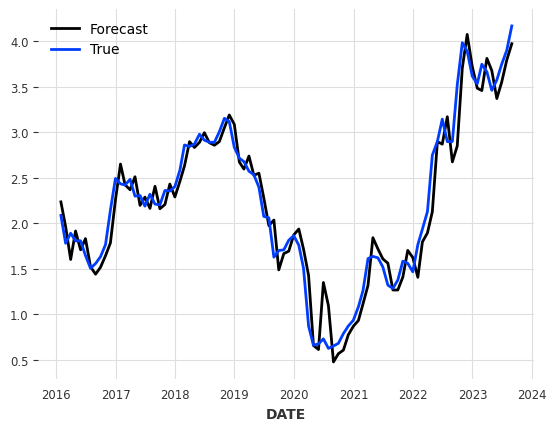

In [53]:
# For each time step in the validation set, fit a new model on the history so far and predict the next step
forecasts = pd.DataFrame()
for t in validation.index:

    # Get the history up to the previous month
    hist_t = history[:t - pd.offsets.MonthEnd()]
    # print(hist_t.iloc[-1])

    # Fit the model with data up to the previous month
    model = VAR(hist_t)
    model_fit = model.fit(maxlags=1)

    # Forecast for t + 1
    y_pred = model_fit.forecast(hist_t.values[-model_fit.k_ar:], steps=1)[0][0]
    y_pred_unscaled = utils.unscale_series(TimeSeries.from_times_and_values(values=np.array([y_pred]), times=pd.DatetimeIndex([t], freq="ME")), pipeline, ts_scaled["US_TB_YIELD_10YRS"])
    y_pred_unscaled = y_pred_unscaled.pd_dataframe().rename(columns={"US_TB_YIELD_10YRS": "mean"})



    # print(y_pred.summary_frame())
    forecasts = pd.concat([forecasts, y_pred_unscaled])

# Revert the scaling
fore_unscaled = TimeSeries.from_dataframe(forecasts, value_cols=["mean"])

# Plot the forecast
fore_unscaled.plot(label="Forecast")
val_ts.plot(label="True")

In [56]:
test_result = model_fit.test_causality(caused='US_TB_YIELD_10YRS', causing=['US_CPI'], kind='f', signif=0.05)
test_result.summary()

Test statistic,Critical value,p-value,df
0.4169,3.843,0.519,"(1, 4990)"


In [39]:
model_fit.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 05, Jan, 2025
Time:                     17:03:33
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -21.9455
Nobs:                     510.000    HQIC:                  -22.5007
Log likelihood:          -1297.59    FPE:                1.18187e-10
AIC:                     -22.8588    Det(Omega_mle):     9.54764e-11
--------------------------------------------------------------------
Results for equation US_TB_YIELD_10YRS
                                 coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------------
const                              -0.005512         0.039192           -0.141           0.888
L1.US_TB_YIELD_10YRS               -0.117270         0.214760           -0.546         

In [40]:
# Compute the error metrics
print(f"MAPE: {mape(val_ts, fore_unscaled)}")
print(f"RMSE: {rmse(val_ts, fore_unscaled)}")
print(f"R2: {r2_score(val_ts, fore_unscaled)}")

MAPE: 9.96561076723105
RMSE: 0.21465449043880203
R2: 0.940836249723756


In [28]:
norm = model_fit.test_normality()
norm.summary()

Test statistic,Critical value,p-value,df
812.6,9.488,0.000,4


In [29]:
whiteness = model_fit.test_whiteness()
whiteness.summary()

ValueError: The whiteness test can only be used when nlags is larger than the number of lags included in the model (12).

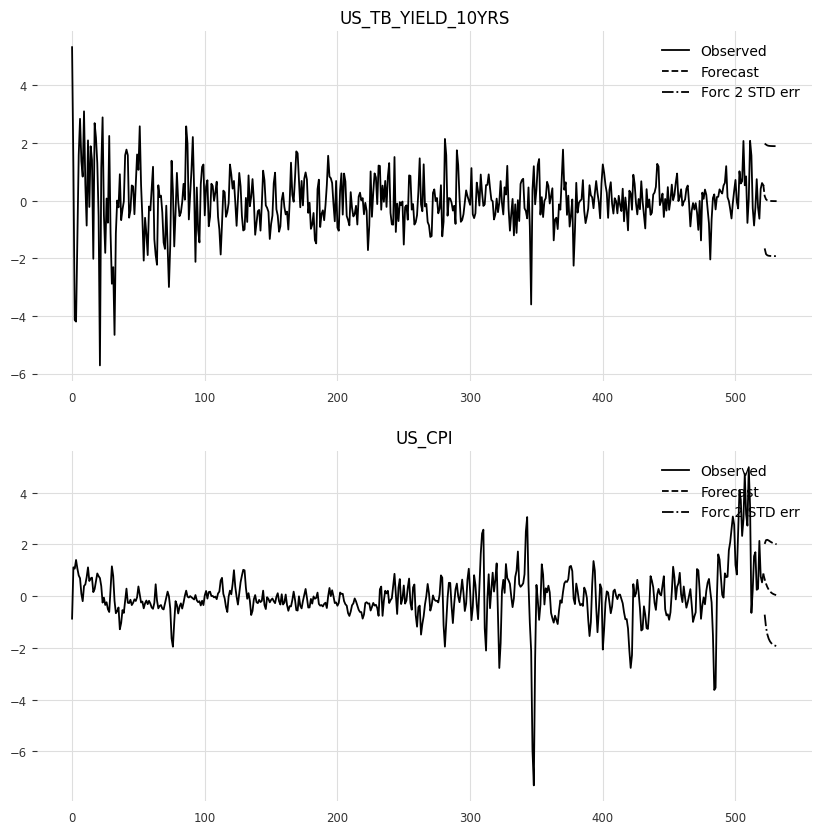

In [ ]:
fig = model_fit.plot_forecast(10)